## Preliminary Analysis of Dominik's 93 Colour Patch Comparison Data

2022-Jan-28  
Ariel Zeleznikow-Johnston

In [292]:
# hardcoded values
n.compare = 320
cor_threshold = 0.5
n.stim = 93
catch_threshold = 70

In [293]:
Sys.setenv(RGL_USE_NULL = TRUE)
library(rgl)
library(stringr)

In [294]:
library(remotes)
remotes::install_github("rstudio/webshot2")


Skipping install of 'webshot2' from a github remote, the SHA1 (6cc8950c) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
library(rsample)

In [5]:
library(webshot2)

In [6]:
library(tidyverse)
install.packages("ramify")
library(dplyr)
library(ggplot2)
install.packages("reshape2")
library(viridis)
library(MASS)
install.packages("hrbrthemes")
library(scales)
library(broom)
install.packages("pglm")
library(gtools)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v forcats 0.5.1
v readr   2.0.2     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



package 'ramify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpKSosfw\downloaded_packages
package 'reshape2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpKSosfw\downloaded_packages


Loading required package: viridisLite


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




package 'hrbrthemes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpKSosfw\downloaded_packages



Attaching package: 'scales'


The following object is masked from 'package:viridis':

    viridis_pal


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




package 'pglm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpKSosfw\downloaded_packages



Attaching package: 'gtools'


The following object is masked from 'package:rsample':

    permutations




### Loading Data

In [7]:
# matching regex of any amount of characters then followed by .csv
files <- list.files(path="./data", pattern="*.csv", full.names=TRUE)
filesizes <- file.size(files)

# individual participant files use a unique ID to mark which colour pairs they saw
truthColourTableColumnNames <- c("r1", "g1", "b1", "r2", "g2", "b2")
truthColourTable <- read.csv("./colourcodes/colourcodes.csv", header=F)
names(truthColourTable) <- truthColourTableColumnNames

# not sure what the point of this is...?
files <- files[-(which(filesizes < 4))]

pilotdata <- sapply(files, read.csv, simplify=FALSE) %>% bind_rows(.id = "fileId")

In [8]:
# changing realcomparison from zero-indexed to one-indexed

participantsIDFrame <- data.frame(unique(pilotdata$participant))

pilotdata <- pilotdata %>% arrange("participant")

In [9]:
# variables of interest from collected data
trial_vars<- c( "participant", "practice_comparison", "pracsimilarity", "realcomparison", "similarity", "response_time", "trials_2.thisN") 
catch_vars<- c("participant", "catch_response_time", "catchnumberprac", "catchpracsimilarity", "catchnumber", "catchsimilarity", "catchRT", "catchtrialorder")
trialdata <- (pilotdata %>% filter(!is.na(realcomparison)))[trial_vars] # no catch trials
catchdata <- (pilotdata %>% filter(!is.na(catchnumber)))[catch_vars] # no main trials
trialdata = rename(trialdata, dissimilarity = similarity)

trialdata$realcomparison <- trialdata$realcomparison + 1 # fixing the indexing?

rgb2hex <- function(r, g, b) {rgb(r, g, b, maxColorValue = 255)}

In [142]:
# getting the colour pair comparison information

# compartmentalising the two dots presented to participants
firstColourSet <- truthColourTable[,truthColourTableColumnNames[1:3]]
secondColourSet <- truthColourTable[,truthColourTableColumnNames[4:6]]

names(firstColourSet) <- names(secondColourSet) <- c("r", "g", "b")

#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
                            
#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))

# colourSetHEX is used as a reference throughout the rest of the analysis for the colour pair comparisons     
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)


### Cleaning Data

##### Catch Trials

In [11]:
# catch trial scoring
#hist(catchdataParticipant$accuracy)


In [12]:
# assess whether participants passed
catch.assess <- function(catchdata){
    catchdata <- catchdata %>% mutate(is_valid_catch_response = if_else(catchnumber == catchsimilarity, 1, 0), is_invalid_catch_response = if_else(catchnumber != catchsimilarity, 1, 0))
    catchdataParticipant <- catchdata %>% group_by(participant) %>% 
      summarise(correct_responses=sum(is_valid_catch_response), incorrect_responses = sum(is_invalid_catch_response))

    catchdataParticipant$total <- catchdataParticipant$correct_responses + catchdataParticipant$incorrect_responses
    catchdataParticipant$accuracy <- (catchdataParticipant$correct_responses/catchdataParticipant$total) * 100
    return(catchdataParticipant)
}

# remove participants who scored below a certain threshold
catch.remove <- function(catchdata, trialdata, threshold){
    catch.participant <- catch.assess(catchdata)
    passed <- subset(catch.participant, accuracy >= threshold)$participant
    clean <- subset(trialdata, trialdata$participant %in% passed)
    return(clean)
}


In [13]:
# clean the trial data
clean.data <- catch.remove(catchdata,trialdata,catch_threshold) # using 80% threshold

##### Within-subject double pass consistency

In [14]:
# each participant should have completed 320 trials
count.remove <- function(data, threshold){
    count <- data %>% count(participant)
    passed <- subset(count, n == threshold)$participant
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- count.remove(clean.data,n.compare)

##### Within-subject double pass consistency

In [15]:
double.pass.check <- function(data){
    v1 <- data$dissimilarity[1:(n.compare/2)]
    v2 <- data$dissimilarity[(n.compare/2+1):n.compare]
    return(cor(v1,v2))
}

pass.remove <- function(data, threshold=cor_threshold){
    IDs <- unique(data$participant)
    passed <- vector()
    for(id in IDs){
        tryCatch(
            {
                if(double.pass.check(subset(data, participant == id)) >= threshold){
                    passed <- c(passed,id)
                }
            },
            error=function(cond){
                message(paste("Something went wrong with correlations for participant:",id))
            }
        )
        
    }
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- pass.remove(clean.data)

Warning message in cor(v1, v2):
"the standard deviation is zero"
Something went wrong with correlations for participant: 60fdee1f5bb38a56c58631bc



### Descriptive plots & statistics

##### Matrix Visualisations

Setting up the matrix

In [16]:
# read in the colour comparison truth table
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)

rowsTotalSetHEX <- rbind(data.frame(colour = firstColourSetHEX), data.frame(colour = secondColourSetHEX)) %>% group_by_all %>% count

# preliminary check that the data has been read in correctly
countOfUniqueRowsFirstSet <- length(unique(firstColourSetHEX))
countOfUniqueRowsSecondSet <- length(unique(secondColourSetHEX))
countOfUniqueRowsTotalSet <- length(rowsTotalSetHEX$colour)

In [17]:
# set lower triangle of matrix to NA - this gives heatmap its unique upper triangle
upperTriangularMatrix <- upper.tri(matrix(1, ncol = countOfUniqueRowsTotalSet, nrow = countOfUniqueRowsTotalSet), 
                              diag = FALSE)
upperTriangularMatrix[upperTriangularMatrix == 1] <- NA
color.mat.df <- data.frame(upperTriangularMatrix)
color.mat <- upperTriangularMatrix

#head(uniqueColourCountDF)

In [18]:
# setting all give colours as both row and column names
colnames(color.mat.df) <- rownames(color.mat.df) <- rowsTotalSetHEX$colour
colnames(color.mat) <- rownames(color.mat) <- rowsTotalSetHEX$colour

Matrix plot of group mean for each comparison

In [19]:
# get mean dissimilarity for each colour comparison
group.mean <- clean.data %>% 
                group_by(realcomparison) %>% 
                summarise(across(dissimilarity, mean, na.rm = TRUE))

In [20]:
# create a mean dissimilarity dataframe using realcomparison indexing
group.avg.df <- function(data, colors.df){
    means.df <- data %>%
                group_by(realcomparison) %>%
                summarise(across(dissimilarity, mean, na.rm = TRUE))
    # sorting 
    means.df$realcomparison <- as.numeric(means.df$realcomparison)
    means.df <- means.df[order(means.df$realcomparison),]
    colors.df$value <- means.df$dissimilarity
    return(colors.df)
}

In [21]:
gp.mean.data <- colourSetHEX
gp.mean.data$value <- group.mean$dissimilarity

In [22]:
#head(gp.mean.data)

In [23]:
# fill matrix
matrix.df.fill <- function(data,matrix.df){
    for(i in 1:nrow(data)){
        #print(i)
        row <- data[i,]
        #print(matrix.df[row$firstColour,row$secondColour])
        matrix.df[row$firstColour,row$secondColour] <- row$value
        matrix.df[row$secondColour,row$firstColour] <- row$value # symmetric
        #print(matrix.df[row$firstColour,row$secondColour])
    }
    return(matrix.df)
}

In [24]:
group.mean.mat.df <- matrix.df.fill(gp.mean.data,color.mat.df)


In [25]:
# for visualisation purposes, make a column value indicating correlation with first row
row.cor <- function(df){
    v.cor <- vector()
    for(i in 1:nrow(df)){
        v.cor <- c(v.cor, cor(df[1],df[i]))
    }    
    return(v.cor)
}

row.factors <- function(colors, correlations){
    colors$cor <- correlations
    ordered <- colors[order(-colors$cor),]
    return(ordered$colour)
}

row.facs <- row.factors(rowsTotalSetHEX,row.cor(group.mean.mat.df))

In [26]:
group.mean.mat.df$color1 <- rowsTotalSetHEX$colour
group.mean.mat.df$color2 <- rowsTotalSetHEX$colour

In [27]:
#head(group.mean.mat.df)

In [28]:
group.mean.df <- gather(group.mean.mat.df, color1, mean,
                        rowsTotalSetHEX$colour[1]:rowsTotalSetHEX$colour[nrow(rowsTotalSetHEX)],
                       factor_key=TRUE)

In [29]:
group.mean.df$color1 <- with(group.mean.df, factor(color1, levels = row.facs))
group.mean.df$color2 <- with(group.mean.df, factor(color2, levels = row.facs))

In [30]:
# plot the matrix
matrix.mean <- ggplot(group.mean.df, aes(x = color1, y = color2, fill = log(mean+1))) + geom_raster() + ggtitle('log(dissimilarity+1)') +
    theme(axis.text.x = element_text(colour=row.facs, angle=90),
         axis.text.y = element_text(colour=row.facs)) +
    scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,log(7+1)),
                        breaks=c(0,1,2,3,4,5,6,7))
ggsave("log mean dissim matrix.png",matrix.mean,height=15,width=17)
    

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


Check for triangle inequality violations

In [268]:
head(group.mean.mat.df)

,#010300,#022C88,#02529A,#032040,#03406F,#034E49,#086E79,#09384C,#0A3B38,#0C4FA2,⋯,#F6F7F1,#FAAF99,#FAC88D,#FB702E,#FBA628,#FBEC77,#FCDD2A,#FF8F00,color1,color2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
#010300,0.000000,5.1818182,5.9000000,3.8214286,5.1666667,4.733333,5.117647,3.7500000,4.029412,5.350000,⋯,6.500000,6.605263,6.333333,6.833333,6.675000,6.500000,5.733333,6.619048,#010300,#010300
#022C88,5.181818,0.1956522,1.1578947,2.5833333,0.9375000,3.181818,2.500000,2.5625000,4.923077,1.600000,⋯,6.233333,5.800000,6.000000,6.545455,6.000000,5.928571,5.657895,6.088235,#022C88,#022C88
#02529A,5.900000,1.1578947,0.7352941,2.9210526,1.5714286,3.541667,2.075000,2.9444444,3.250000,0.500000,⋯,6.035714,5.472222,6.142857,6.092593,6.538462,6.038462,6.666667,5.631579,#02529A,#02529A
#032040,3.821429,2.5833333,2.9210526,0.8076923,1.7692308,3.472222,2.875000,0.8333333,2.200000,3.157895,⋯,6.136364,6.352941,6.033333,6.229167,6.025000,6.058824,6.041667,6.263158,#032040,#032040
#03406F,5.166667,0.9375000,1.5714286,1.7692308,0.7941176,3.277778,2.846154,1.4500000,3.136364,1.781250,⋯,6.000000,5.788462,6.357143,6.208333,6.200000,5.961538,5.625000,6.000000,#03406F,#03406F
#034E49,4.733333,3.1818182,3.5416667,3.4722222,3.2777778,1.045455,2.115385,2.1250000,0.800000,2.900000,⋯,6.342105,6.406250,5.307692,5.750000,5.970588,5.785714,5.625000,6.343750,#034E49,#034E49


In [31]:
# get rid of extraneous columns
mean.mat.df <- subset(group.mean.mat.df, select = c(-color1, -color2))
mean.mat <- data.matrix(mean.mat.df)


In [32]:
mean.mat[lower.tri(mean.mat, diag = FALSE)] <- NA
#head(mean.mat)

In [33]:
# test for triangle inequality violation given three values
tri.violate <- function(vals){
        
    vals <- sort(vals) # sort from smallest to largest dissimilarity
    if(anyNA(vals)){
        return(FALSE) # don't bother with NAs, e.g. in lower triangle of matrix
    }
    if(vals[3] > (vals[1] + vals[2])){ # I think this is all that's needed
        return(TRUE)
    } else if (vals[2] > vals[1] + vals[3]) { # don't think this is possible
        return(TRUE)
    } else if (vals[1] > vals[2] + vals[1]){ # don't think this is possible
        return(TRUE)
    }
    else {
        return(FALSE)
    }
}

In [34]:
# perform the test across all of a subject's judgments
mat.tri.violate <- function(mat){
    n.stim <- nrow(mat)
    violations <- list()
    i.violate = 1
    for(i in 1:(n.stim-3)){
        for(j in (i+1):(n.stim-2)){
            k = 1
            while(k < (n.stim-j+1)){
                
                #testing
                #print(paste("i:",i,"j:",j,"k:",k,"k+j",k+j))
                
                stimuli <- c(i,j,j+k)
                d.ij <- mat[i,j]
                d.jk <- mat[j,j+k]
                d.ik <- mat[i,j+k]
                vals <- c(d.ij, d.jk, d.ik)
                if(tri.violate(vals)){
                    violations[[i.violate]] <- stimuli
                    i.violate <- i.violate+1
                }
                k <- k + 1
            }
        }
    }
    return(violations)
}

In [35]:
score.tri.violate <- function(mat){
    count <- length(mat.tri.violate(mat))
    n.stim <- nrow(mat)
    n.combo <- length(combinations(n.stim,3)) / 2 # is this right? Removing symmetry redundancy?
    return(count/n.combo)
}

In [ ]:
score.tri.violate(mean.mat)

Check normalised trace

In [ ]:
group.norm.trace <- sum(diag(mean.mat))/nrow(mean.mat)
group.norm.trace

##### Dissimilarity Distributions

In [ ]:
# distribution of dissimilarity values
dissim.distr <- ggplot(group.mean.df, aes(x=mean)) + geom_histogram(binwidth=0.25) +
                xlim(0,7) + xlab('Dissimilarity') + ggtitle('Group Mean') + scale_y_continuous(trans='log1p')
dissim.distr

In [ ]:
log.dissim.distr <- ggplot(group.mean.df, aes(x=log(mean))) + geom_histogram() +
                xlim(0,log(7)) + xlab('log(Dissimilarity)') + ggtitle('Group Mean') + scale_y_continuous(trans='log1p')
log.dissim.distr

### Additional visualisations

Data distribution of a beta distribution - can I visualise the data using MDS after putting the data through a beta distribution link function?

In [265]:
# set up the MDS matrix
data2dist <- function(mat){
    return(as.dist(t(mat), diag=TRUE))
}

data.dist <- data2dist(mean.mat)

In [298]:
visualise3d <- function(dist,name,classical=TRUE,diagnose=FALSE){
    
    
    dir.create(name)
    if(classical){
        mean.mds <- cmdscale(dist, k = 3, eig=TRUE)
    } else {
        name <- paste(name,'non-metric',sep='_')
        mean.mds <- isoMDS(dist, k = 3, eig=TRUE, maxit=100)
    }
    
    # Create x, y, z refs
    data.x <- mean.mds$points[,1]
    data.y <- mean.mds$points[,2]
    data.z <- mean.mds$points[,3]
    # plot
    colors <- colnames(mean.mat)

    plot <- plot3d(data.x,data.y,data.z, col = colors, size = 10)

    dir.create(paste(name,'/animation/',sep=''))

    by = 10
    if(diagnose){
        by=120
    }
        
    for(i in seq(0,350, by)){ # make an animation
        view3d(theta=i)
        save.name <- paste(name,'/animation/',str_pad(i,4,pad='0'),'.png',sep='')
        snapshot3d(save.name, fmt = 'png',
                width = 1000, height = 1000)
    }
}

# ImageMagick code to turn it into a .gif
#magick -delay 40 *.png -loop 0 movie.gif

In [85]:
plot(mean.mds$eig, col = 'red', xlim=c(1,10), ylim = c(0,13000))

ERROR: Error in plot(mean.mds$eig, col = "red", xlim = c(1, 10), ylim = c(0, : object 'mean.mds' not found


In [86]:
mean.mds$GOF

ERROR: Error in eval(expr, envir, enclos): object 'mean.mds' not found


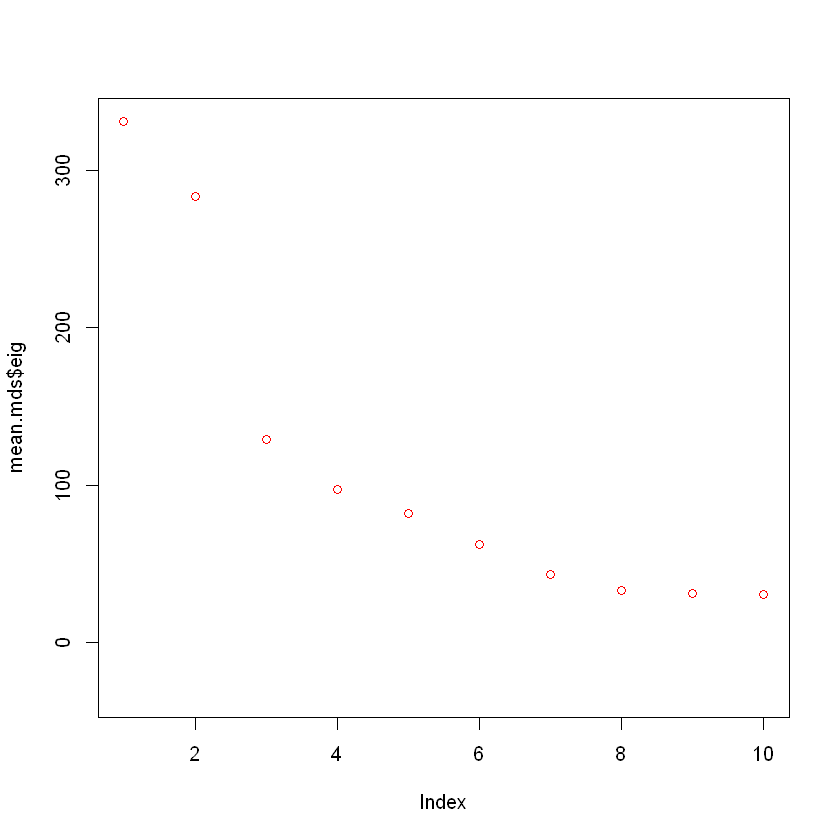

In [130]:
mean.mds <- cmdscale(data.dist, k = 3, eig=TRUE)
plot(mean.mds$eig, col = 'red', xlim=c(1,10))

In [131]:
log.mean.mds <- cmdscale(log(data.dist+1), k = 3, eig=TRUE)

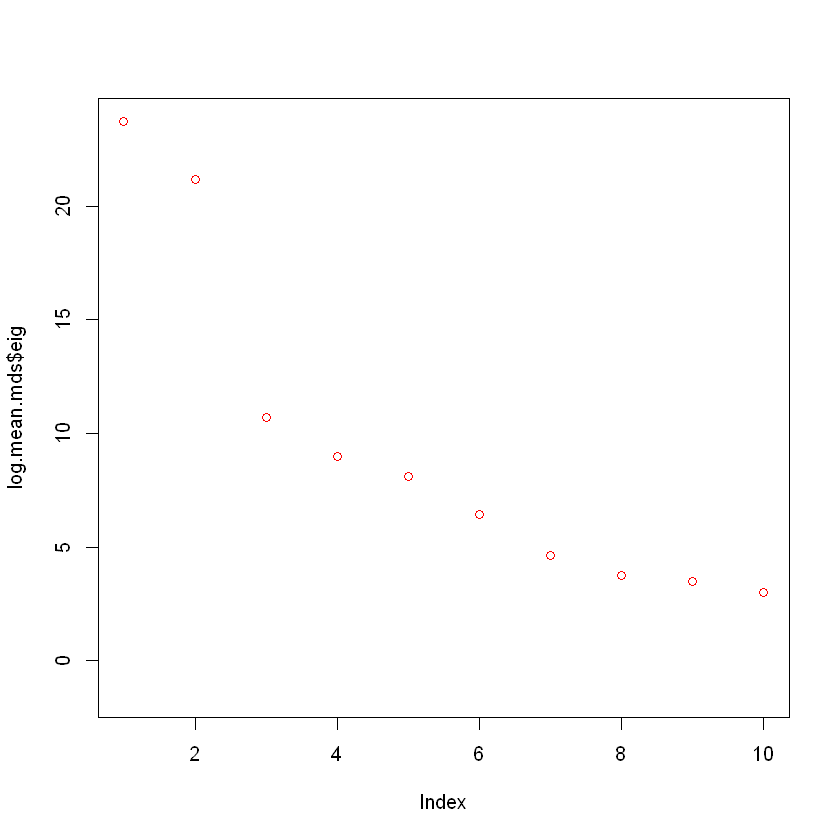

In [132]:
plot(log.mean.mds$eig, col = 'red', xlim=c(1,10))

In [110]:
visualise3d(log(data.dist),'log mean')

In [109]:
visualise3d((data.dist),'raw fixed')

In [ ]:
visualise3d((data.dist),'raw', classical=FALSE)

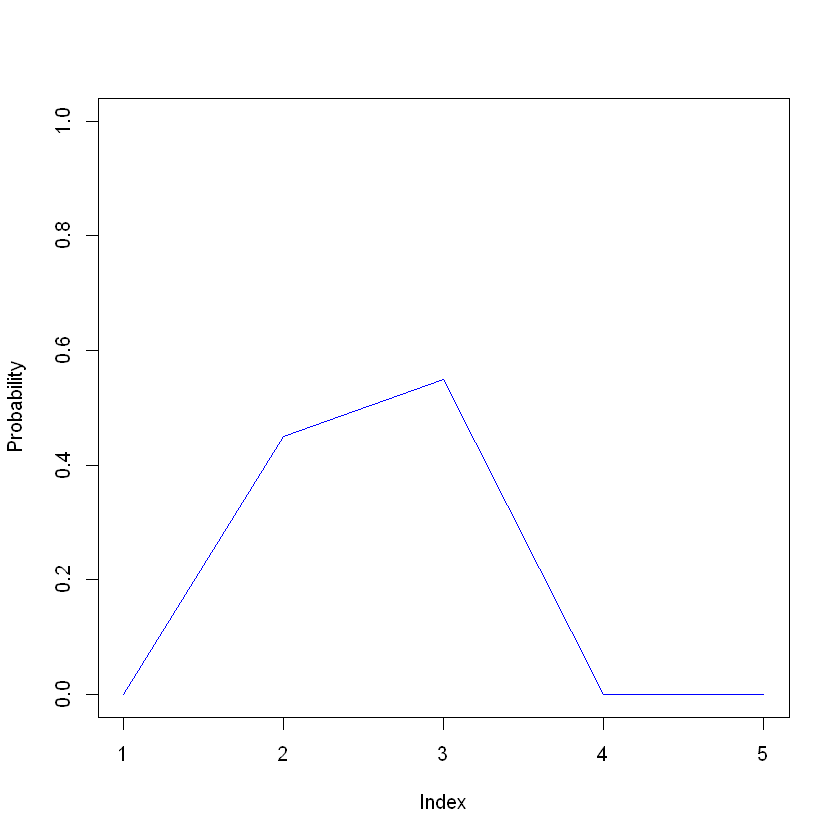

In [136]:
Probability <- c(0,0.45,0.55,0,0) 
plot(Probability, col = 'blue', ylim=c(0,1), type = 'l')

### Model Prediction Accuracy Tests Through Cross-Validation

Ok, the plan is:  
1. Divide aggregate colour comparisons data into ~10 sets, producing 10 full dissimilarity matrices but with only 10% of the judgments per entry  
2. Derive MDS solution for 9 of the sets  
3. Use 9 sets to calculate expected dissimilarity between colours (expected dissimilarity matrix)  
4. Calculate SSE between constructed matrix and holdout set  
5. Compare raw data vs. log data by normalising total variance of reserved set  


In [258]:
# split the data into 10 sets
split.data <- function(data, n_split,method='data'){
    data$realcomparison <- as.character(data$realcomparison)
    output <- list()
    data$ID <- seq.int(nrow(data))
    if(method=='data'){
        for(i in 1:n_split){
        
            out <- data %>%
                group_by(realcomparison) %>%
                sample_frac(1/n_split,replace=FALSE) # select fraction of data
            
            data[!(data$ID %in% out$ID),] # remove selected data from original data
            out <- subset(out, select = -c(ID)) # remove ID column
            #print(head(out)) # testing
            output[[i]] <- out # add to output list
        }
        
    }   else if (method=='participant'){
            # this works algorithmically, but is not useful
            # random participant splitting means that some comparisons are not
            # sampled for any number of groups greater than 2, which is useless
            # I'll need to write a cleverer algorithm for this
            output <- initial_split(data, 
                                 prop=1-1/n_split)   
    }
    
    return(output)
}

In [37]:
#shuffled_data= clean.data[sample(1:nrow(clean.data)), ]

#temp.grouped  <- shuffled_data %>%
 # group_by(participant,realcomparison) %>%
  #mutate(isTrainingSet = (row_number() <= 0.1 * n())) %>%
  #ungroup()

#firstHalf <- filter(temp.grouped , isTrainingSet)
#secondHalf <- filter(temp.grouped , !isTrainingSet)

In [38]:
#nrow(firstHalf)
#print(length(unique(firstHalf$realcomparison)))
#print(length(unique(clean.data$realcomparison)))

In [39]:
#temp <- clean.data
#temp$realcomparison <- as.character(temp$realcomparison)
#splitObj <- initial_split(temp,
 #                        prop = 0.25,
  #                       strata=realcomparison)
#nrow(clean.data)
#print(length(unique(clean.data$realcomparison)))
#train <- training(splitObj)
#nrow(train)
#print(length(unique(train$realcomparison)))

In [40]:
#clean.split.participant <- split.data(clean.data, 10, method='participant')

In [41]:
clean.split.data <- split.data(clean.data, 10, method='data')


In [42]:
mean.matrix.list <- function(split.list){
    n <- length(split.list)
    output <- list()
    
    for(i in 1:n){
        mean.df <- group.avg.df(split.list[[i]], colourSetHEX)
        mean.mat <- matrix.df.fill(mean.df, color.mat.df)
        output[[i]] <- mean.mat
    }
    return(output)
}

In [43]:
split.mats.data <- mean.matrix.list(clean.split.data)


In [44]:
for(i in 1:length(clean.split.data)){
    print(length(unique(clean.split.data[[i]]$realcomparison)))
}

[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371
[1] 4371


In [45]:
for(i in 1:length(clean.split.participant)){
    print(length(unique(clean.split.participant[[i]]$realcomparison)))
}

ERROR: Error in eval(expr, envir, enclos): object 'clean.split.participant' not found


In [ ]:
#split.mats.participant <- mean.matrix.list(clean.split.participant)

In [191]:
# plot a matrix
mean.matrix.plot <- function(df,name,log=FALSE,symmetry=TRUE,skip.mean=FALSE){
    if(skip.mean){
        mean.df <- df
    } else{
        mean.df <- group.avg.df(df, colourSetHEX)
    }
    #print(log)
    #print(head(mean.df))
    #row.facs <- row.factors(rowsTotalSetHEX,row.cor(mean.df))
    #mean.df$color1 <- rowsTotalSetHEX$colour
    #mean.df$color2 <- rowsTotalSetHEX$colour
    mean.df$color1 <- with(mean.df, factor(firstColour, levels = row.facs))
    mean.df$color2 <- with(mean.df, factor(secondColour, levels = row.facs))
    
    if(symmetry){
        sym.data <- mean.df
        sym.data$C1 <- mean.df$color1
        sym.data$C2 <- mean.df$color2
        sym.data$color1 <- sym.data$C2
        sym.data$color2 <- sym.data$C1
        sym.data <- subset(sym.data, select = -c(C1, C2))
        #print(colnames(mean.df))
        #print(colnames(sym.data))
        mean.df <- rbind(mean.df,sym.data)
    }
    
    if(log){
        name <- paste(name,'_log_',sep='')
        plot <- ggplot(mean.df, aes(x = color1, y = color2, fill = log(value+1))) + 
        geom_raster() + ggtitle('log(dissimilarity+1)') +
        theme(axis.text.x = element_text(colour=row.facs, angle=90),
             axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,log(7+1)),
                        breaks=c(0,1,2,3,4,5,6,7))
    } else {
        plot <- ggplot(mean.df, aes(x = color1, y = color2, fill = value)) + 
        geom_raster() + ggtitle('dissimilarity') +
        theme(axis.text.x = element_text(colour=row.facs, angle=90),
             axis.text.y = element_text(colour=row.facs)) +
        scale_fill_gradientn(colours = c("white","black"),
                        limits = c(0,7),
                        breaks=c(0,1,2,3,4,5,6,7))
    }
    name <- paste(name,'.png',sep='')
    ggsave(name,plot,height=15,width=17)
}

In [47]:
# plot a set of matrices in a folder
plot.set.mat <- function(mat.list,name,log=FALSE){
    name <- paste('mat_set/',name,'/',sep='')
    dir.create(name)
    for(i in 1:length(mat.list)){
        mat_name <- paste(name,i,sep='')
        mean.matrix.plot(mat.list[[i]],mat_name,log=log)
    }
}

In [48]:
#plot.set.mat(clean.split,'CV log',log=TRUE)
#plot.set.mat(clean.split.participant)

In [49]:
# convert a similarity judgment dataframe to a distance matrix for MDS
dist.create <- function(data){
        #print(head(data))
        mean.data.temp <- group.avg.df(data,colourSetHEX)
        dist.temp <- matrix.df.fill(mean.data.temp,color.mat.df)
        #print(head(dist.temp))
        #dist.temp$color1 <- rowsTotalSetHEX$colour
        #dist.temp$color2 <- rowsTotalSetHEX$colour
        #return(dist.temp)
        dist.mat.temp <- as.dist(t(dist.temp), diag=TRUE)
        #print(head(dist.mat))
        return(dist.mat.temp)
}

In [50]:
# make a set of 3D visualisations
plot.set.3D <- function(data.list, name, log=FALSE,quick=TRUE){
    folder.str <- 'CV 3D sets/'
    dir.create(folder.str)
    if(log){
        name <- paste(name,'_log',sep='')
    }
    dir.create(paste(folder.str,name,sep=''))
    
    for(i in 1:length(data.list)){
        subfolder.str <- paste(folder.str,name,'/',i,sep='')
        dir.create(subfolder.str)
        
        dist.mat <- dist.create(data.list[[i]])
        
        print(subfolder.str)
        if(log){
            visualise3d(log(dist.mat+1),subfolder.str,diagnose=quick)
        } else {
            visualise3d(dist.mat,subfolder.str,diagnose=quick)
        }
    }
}

In [69]:
# put everything together, do a certain number of splits
cv.visual <- function(data,n_split,name,log=FALSE,quick=TRUE){
    data.temp <- split.data(data, n_split,method='data')
    name <- paste(name,'_n_split_',n_split,sep='')
    plot.set.3D(data.temp,name,log=log,quick=quick)
    plot.set.mat(data.temp,name,log=log)
}

In [303]:
cv.visual(clean.data,2,'raw',quick=FALSE)
#cv.visual(clean.data,1,'log',log=TRUE,quick=FALSE)

Warning message in dir.create(folder.str):
"'CV 3D sets' already exists"
Warning message in dir.create(paste(folder.str, name, sep = "")):
"'CV 3D sets\raw_n_split_2' already exists"
Warning message in dir.create(subfolder.str):
"'CV 3D sets\raw_n_split_2\1' already exists"


[1] "CV 3D sets/raw_n_split_2/1"


Warning message in dir.create(name):
"'CV 3D sets\raw_n_split_2\1' already exists"
Warning message in dir.create(paste(name, "/animation/", sep = "")):
"'CV 3D sets\raw_n_split_2\1\animation' already exists"


ERROR: Error in s$close(): attempt to apply non-function


In [53]:
#plot.set.3D(clean.split.data,'raw')
#plot.set.3D(clean.split.data,'log',log=TRUE) 

#### Calculate correlations when splitting the data

Let's just compare the correlation and SSE between partitions of the data

Two different ways Nao will want to see for doing this:  
* Holdout judgments (e.g. 10% of judgments in the test set)
* Holdout participants (e.g. 10% of participants in the test set)

##### Holdout Judgments

Make a group mean matrix using 10-90% of the data in 10% increments, observe performance on predicting the judgments in the 10% holdout set

In [57]:
# format the training & test data
cv.data.judge <- split.data(clean.data, 10, method='data')
test.data <- cv.data.judge[[10]]

train.10 <- group.avg.df(cv.data.judge[[1]], colourSetHEX)
test.data.avg <- group.avg.df(test.data, colourSetHEX)

In [277]:
# plot the correlation between two datasets
cor.plot <- function(train,test,log=FALSE,xlabel='Training data',ylabel='Test data'){
    vals.df <- as.data.frame(c(train,test))

    if(log){
        vals.df$value <- log(vals.df$value+1)
        vals.df$value.1 <- log(vals.df$value.1+1)
    }
    plot <- ggplot(data = vals.df, aes(x = value, y = value.1)) + geom_point() +
            xlab(xlabel) + ylab(ylabel) +
            geom_smooth(method = 'lm', alpha = 0.15) +
            xlim(0,7) + ylim(0,7)
    print(plot)
    return(vals.df)
}

In [96]:
# calculate standard squared erro
SSE <- function(lm){
    out <- sum((lm$fitted.values - mean(lm$fitted.values))^2)
    print(paste("SSE:",out))
    return(out)
}

In [99]:
var(test.data.avg$value)
var(log(test.data.avg$value+1))

[1] 2.71224

[1] 0.1425047

In [61]:
data.90 <- rbind(cv.data.judge[[1]],
                 cv.data.judge[[2]],
                 cv.data.judge[[3]],
                 cv.data.judge[[4]],
                 cv.data.judge[[5]],
                 cv.data.judge[[6]],
                 cv.data.judge[[7]],
                 cv.data.judge[[8]],
                 cv.data.judge[[9]],
                )

In [62]:
train.90 <- group.avg.df(data.90, colourSetHEX)


  firstColour secondColour     value
1     #E088A1      #E088A1 0.5714286
2     #E088A1      #C4577A 1.9333333
3     #E088A1      #B06079 2.9000000
4     #E088A1      #9C1C53 3.6842105
5     #E088A1      #7C3D4E 3.8571429
6     #E088A1      #7D0B45 3.4545455
  firstColour secondColour    value
1     #E088A1      #E088A1 0.500000
2     #E088A1      #C4577A 2.333333
3     #E088A1      #B06079 3.000000
4     #E088A1      #9C1C53 3.250000
5     #E088A1      #7C3D4E 3.000000
6     #E088A1      #7D0B45 4.500000
  firstColour secondColour    value firstColour.1 secondColour.1   value.1
1     #E088A1      #E088A1 0.500000       #E088A1        #E088A1 0.5714286
2     #E088A1      #C4577A 2.333333       #E088A1        #C4577A 1.9333333
3     #E088A1      #B06079 3.000000       #E088A1        #B06079 2.9000000
4     #E088A1      #9C1C53 3.250000       #E088A1        #9C1C53 3.6842105
5     #E088A1      #7C3D4E 3.000000       #E088A1        #7C3D4E 3.8571429
6     #E088A1      #7D0B45 4.500000    

`geom_smooth()` using formula 'y ~ x'



  firstColour secondColour     value
1     #E088A1      #E088A1 0.5714286
2     #E088A1      #C4577A 1.9333333
3     #E088A1      #B06079 2.9000000
4     #E088A1      #9C1C53 3.6842105
5     #E088A1      #7C3D4E 3.8571429
6     #E088A1      #7D0B45 3.4545455
  firstColour secondColour     value
1     #E088A1      #E088A1 0.3333333
2     #E088A1      #C4577A 3.3076923
3     #E088A1      #B06079 2.1666667
4     #E088A1      #9C1C53 2.9130435
5     #E088A1      #7C3D4E 3.5000000
6     #E088A1      #7D0B45 3.6363636
  firstColour secondColour     value firstColour.1 secondColour.1   value.1
1     #E088A1      #E088A1 0.3333333       #E088A1        #E088A1 0.5714286
2     #E088A1      #C4577A 3.3076923       #E088A1        #C4577A 1.9333333
3     #E088A1      #B06079 2.1666667       #E088A1        #B06079 2.9000000
4     #E088A1      #9C1C53 2.9130435       #E088A1        #9C1C53 3.6842105
5     #E088A1      #7C3D4E 3.5000000       #E088A1        #7C3D4E 3.8571429
6     #E088A1      #7D0B45

`geom_smooth()` using formula 'y ~ x'



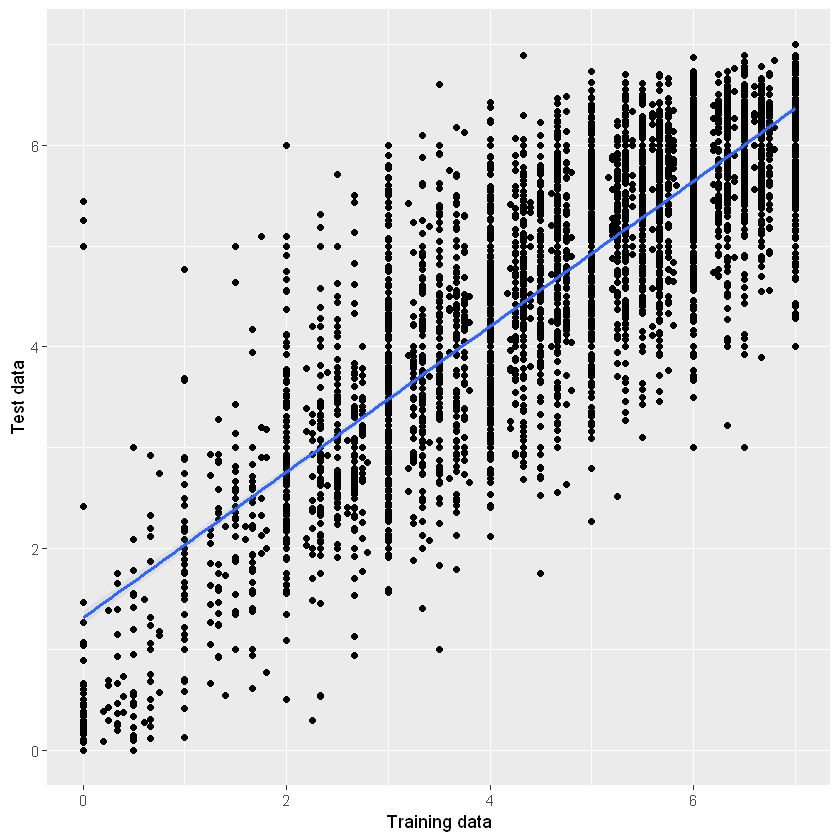

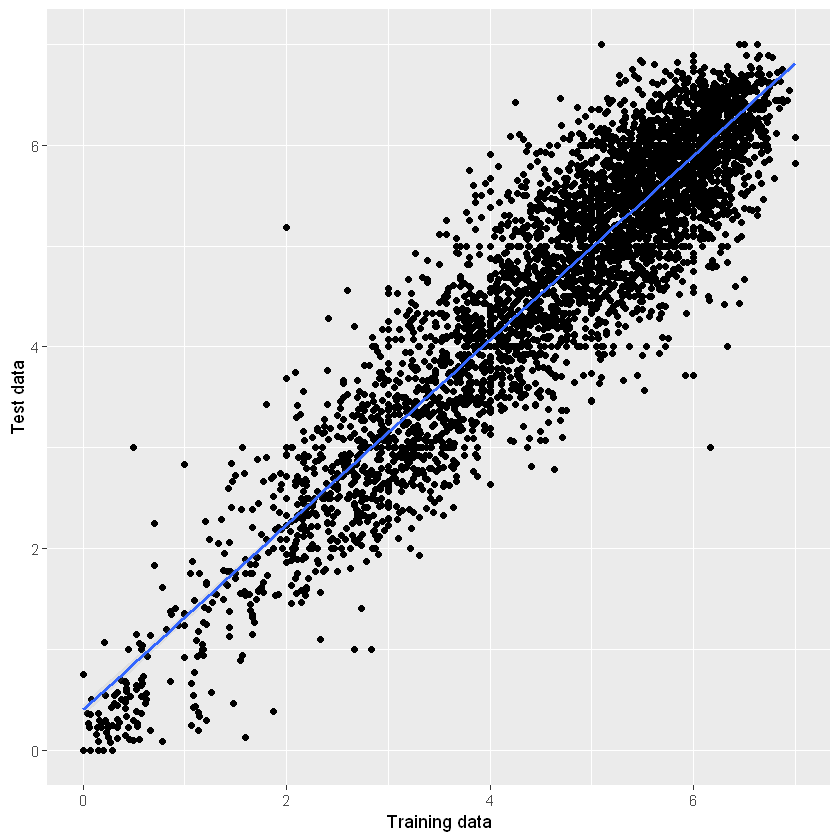

In [216]:
raw.10 <- cor.plot(train.10,test.data.avg, log=FALSE)
raw.90 <- cor.plot(train.90, test.data.avg, log=FALSE)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



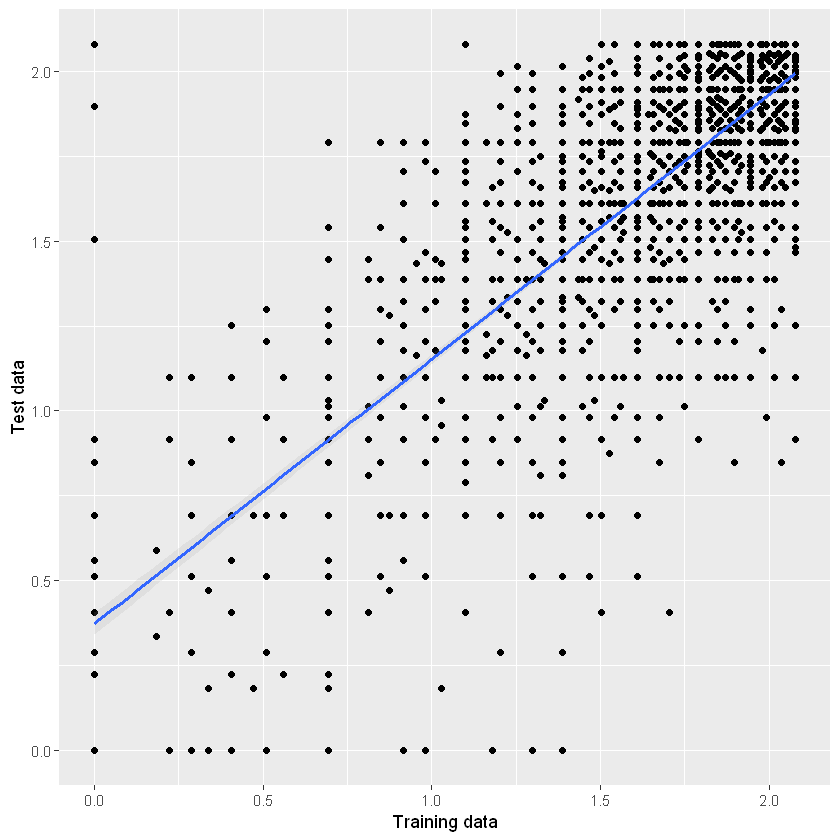

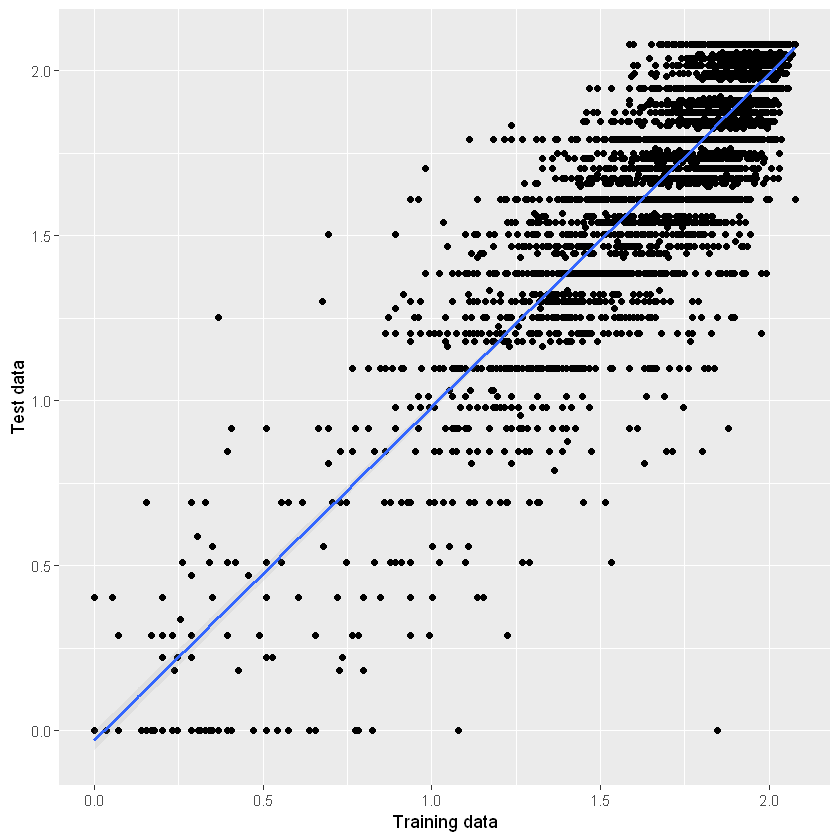

In [77]:
test1 <- cor.plot(train.10,test.data.avg, log=TRUE)
test2 <- cor.plot(train.90, test.data.avg, log=TRUE)

In [78]:
cor(test1$value,test1$value.1)
cor(test2$value,test2$value.1)

[1] 0.777877

[1] 0.8687526

In [103]:
lm.10.raw <- lm(value~value.1, data = raw.10) # 10% training data
summary(lm.10.raw)
SSE(lm.10.raw)
SSE(lm.10.raw)/var(test.data.avg$value)


Call:
lm(formula = value ~ value.1, data = raw.10)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3759 -0.7093  0.0420  0.7223  4.6362 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.26955    0.05109   24.85   <2e-16 ***
value.1      0.72948    0.01024   71.27   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.114 on 4369 degrees of freedom
Multiple R-squared:  0.5376,	Adjusted R-squared:  0.5375 
F-statistic:  5079 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 6307.26631996079"


[1] 6307.266

[1] "SSE: 6307.26631996079"


[1] 2325.482

In [104]:
lm.90.raw <- lm(value~value.1, data = raw.90) # 90% training data
summary(lm.90.raw)
SSE(lm.90.raw)/var(test.data.avg$value)


Call:
lm(formula = value ~ value.1, data = raw.90)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8869 -0.4649  0.0221  0.4863  4.0458 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.287548   0.035279    36.5   <2e-16 ***
value.1     0.725771   0.007068   102.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7694 on 4369 degrees of freedom
Multiple R-squared:  0.7071,	Adjusted R-squared:  0.707 
F-statistic: 1.055e+04 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 6243.23008824304"


[1] 2301.872

In [102]:
lm.10.log <- lm(value~value.1, data = test1) # 10% training data
summary(lm.10.raw)
SSE(lm.10.log)
SSE(lm.10.log)/var(log(test.data.avg$value+1))


Call:
lm(formula = value ~ value.1, data = raw.10)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3759 -0.7093  0.0420  0.7223  4.6362 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.26955    0.05109   24.85   <2e-16 ***
value.1      0.72948    0.01024   71.27   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.114 on 4369 degrees of freedom
Multiple R-squared:  0.5376,	Adjusted R-squared:  0.5375 
F-statistic:  5079 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 375.575360754166"


[1] 375.5754

[1] "SSE: 375.575360754166"


[1] 2635.53

In [105]:
lm.90.log <- lm(value~value.1, data = test2) # 90% training data
summary(lm.90.log)
SSE(lm.90.log)
SSE(lm.90.log)/var(log(test.data.avg$value+1))


Call:
lm(formula = value ~ value.1, data = test2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00783 -0.07597  0.01132  0.08839  1.40708 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.438749   0.011135    39.4   <2e-16 ***
value.1     0.747796   0.006449   115.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1609 on 4369 degrees of freedom
Multiple R-squared:  0.7547,	Adjusted R-squared:  0.7547 
F-statistic: 1.344e+04 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 348.238039121259"


[1] 348.238

[1] "SSE: 348.238039121259"


[1] 2443.696

##### Holdout Participants

Make a group mean matrix using 90% of participants, observe performance on predicting the judgments in the 10% holdout set

In [116]:
cv.data.judge <- split.data(clean.data, 2, method='participant')

In [117]:
# format the training & test data
train.90 <- group.avg.df(training(cv.data.judge), colourSetHEX)
test.data <- testing(cv.data.judge)

test.data.avg <- group.avg.df(test.data, colourSetHEX)

`geom_smooth()` using formula 'y ~ x'



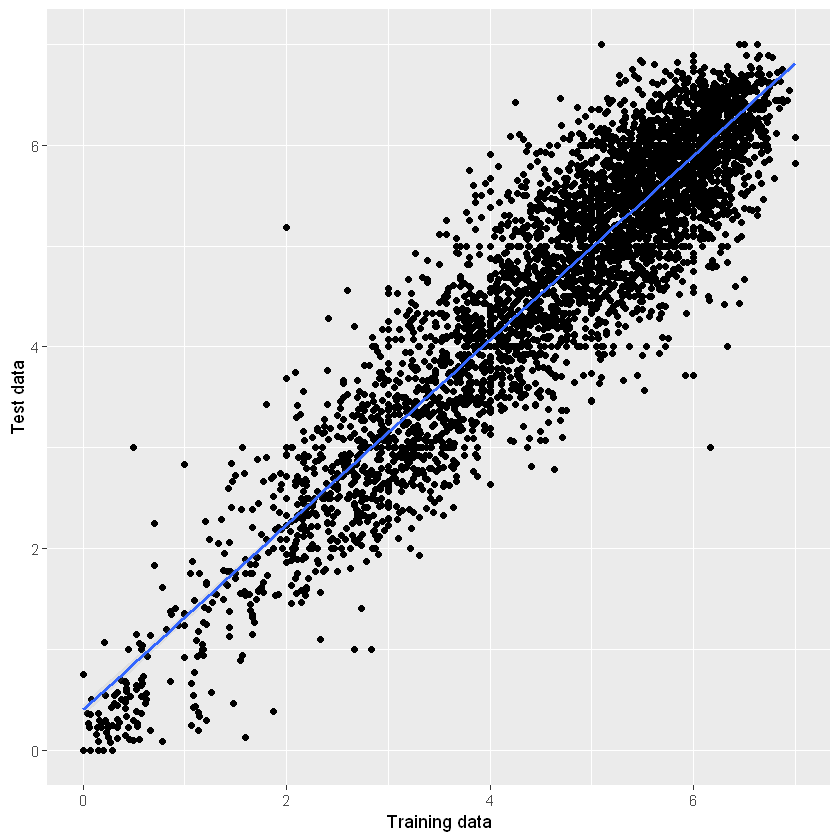

In [118]:
raw.90 <- cor.plot(train.90, test.data.avg, log=FALSE)

`geom_smooth()` using formula 'y ~ x'



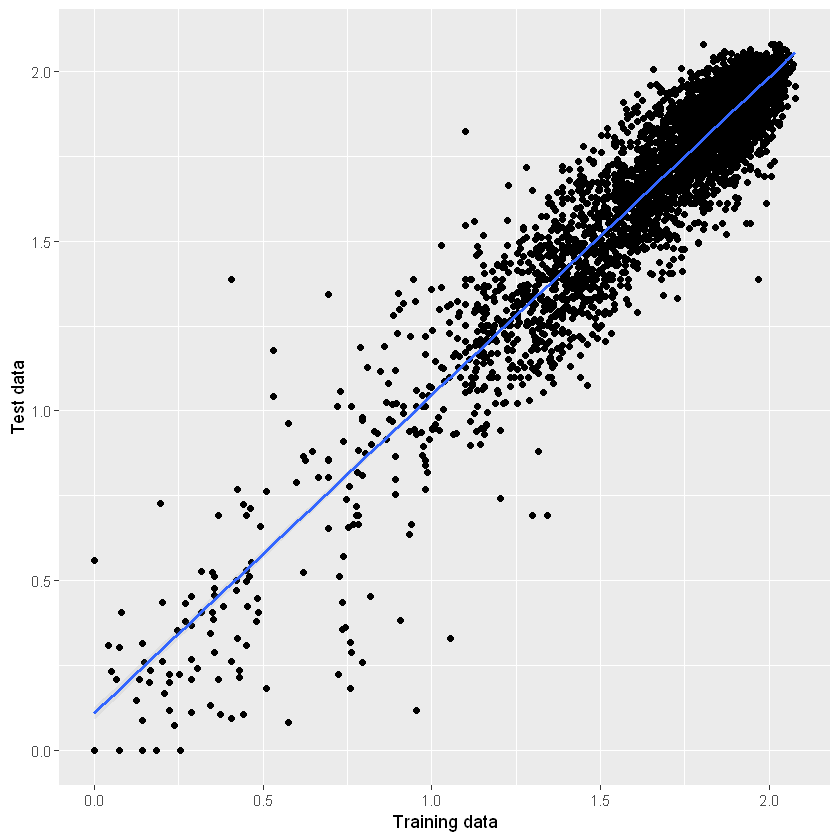

In [119]:
test2 <- cor.plot(train.90, test.data.avg, log=TRUE)

In [123]:
cor(raw.90$value,raw.90$value.1)
cor(test2$value,test2$value.1)

[1] 0.9176941

[1] 0.9343892

In [121]:
lm.90.raw <- lm(value~value.1, data = raw.90) # 90% training data
summary(lm.90.raw)
SSE(lm.90.raw)/var(test.data.avg$value)


Call:
lm(formula = value ~ value.1, data = raw.90)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.13748 -0.35121  0.00973  0.35904  3.03484 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.374062   0.029628   12.62   <2e-16 ***
value.1     0.919256   0.006021  152.68   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5649 on 4369 degrees of freedom
Multiple R-squared:  0.8422,	Adjusted R-squared:  0.8421 
F-statistic: 2.331e+04 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 7439.18620163902"


[1] 3692.789

In [122]:
lm.90.log <- lm(value~value.1, data = test2) # 90% training data
summary(lm.90.log)
SSE(lm.90.log)
SSE(lm.90.log)/var(log(test.data.avg$value+1))


Call:
lm(formula = value ~ value.1, data = test2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00082 -0.05986  0.00657  0.06680  0.73212 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.113563   0.009307    12.2   <2e-16 ***
value.1     0.932505   0.005379   173.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1155 on 4369 degrees of freedom
Multiple R-squared:  0.8731,	Adjusted R-squared:  0.8731 
F-statistic: 3.006e+04 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 400.834871922438"


[1] 400.8349

[1] "SSE: 400.834871922438"


[1] 3800.003

#### Calculate predicted distances from the MDS models

Ok, now let's see how well this works when we derive the dissimilarity matrix from the MDS model. We're going to lose some performance due to throwing away some information, but let's see how well it works

##### MDS Model to Dissimilarity Matrix

In [234]:
# euclidean distance
euclidean <- function(a, b){return(sqrt(sum((a-b)^2)))}

In [235]:
# find the dissimilarity between two colours in an MDS model
dissim.dist <- function(colour1, colour2, mds, method='euclidean'){
    x <- mds$points[colour1,]
    y <- mds$points[colour2,]
    if(method=='euclidean'){
        val <- euclidean(x, y)
        return(val) 
    }
}

In [236]:
# populate a dissimilarity df using an MDS model

mds2df <- function(mds, method='euclidean'){
    empty <- colourSetHEX
    empty$value <- NA
    for(row in 1:nrow(empty)){
        empty[row,3] <- dissim.dist(empty[row,1],
                           empty[row,2],
                           mds=mds,method=method)
    }
    return(empty)
}

In [237]:
test <- mds2df(mean.mds)

In [195]:
mean.matrix.plot(test,'test',skip.mean=TRUE)

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."
Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


In [238]:
head(test.data.avg)
head(test)

,firstColour,secondColour,value
,<chr>,<chr>,<dbl>
1,#E088A1,#E088A1,0.5714286
2,#E088A1,#C4577A,1.9333333
3,#E088A1,#B06079,2.9000000
4,#E088A1,#9C1C53,3.6842105
5,#E088A1,#7C3D4E,3.8571429
6,#E088A1,#7D0B45,3.4545455


,firstColour,secondColour,value
,<chr>,<chr>,<dbl>
1,#E088A1,#E088A1,0.0000000
2,#E088A1,#C4577A,0.7191488
3,#E088A1,#B06079,0.9987285
4,#E088A1,#9C1C53,2.0135018
5,#E088A1,#7C3D4E,2.0592994
6,#E088A1,#7D0B45,2.3037880


`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 10 rows containing missing values (geom_smooth)."


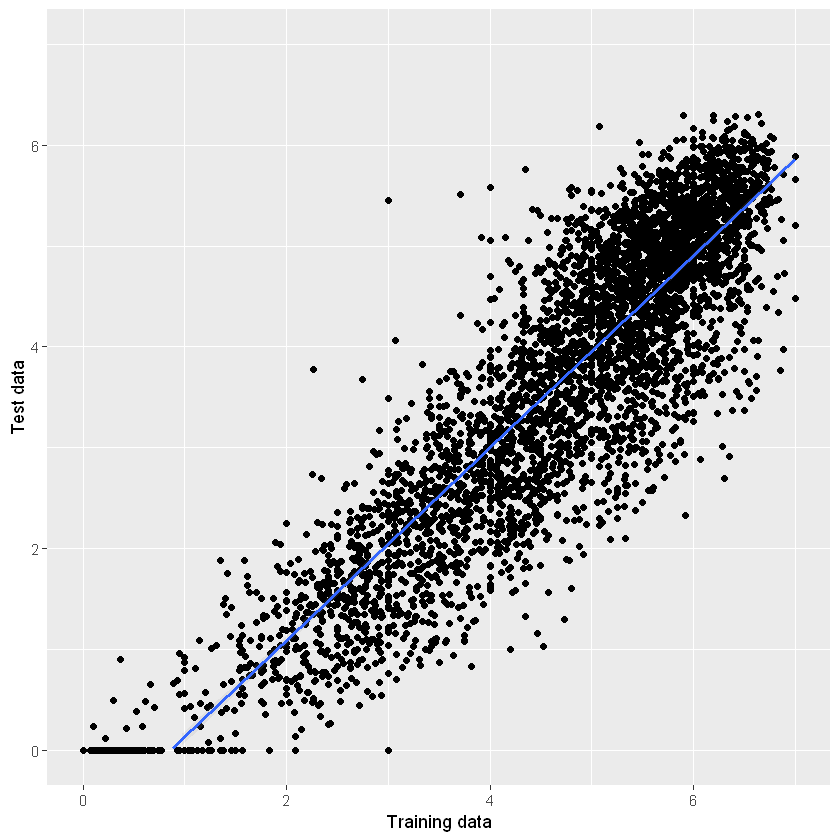

In [241]:
bum <- cor.plot(test.data.avg,test)

50-50 split, 3D Euclidean Model

`geom_smooth()` using formula 'y ~ x'



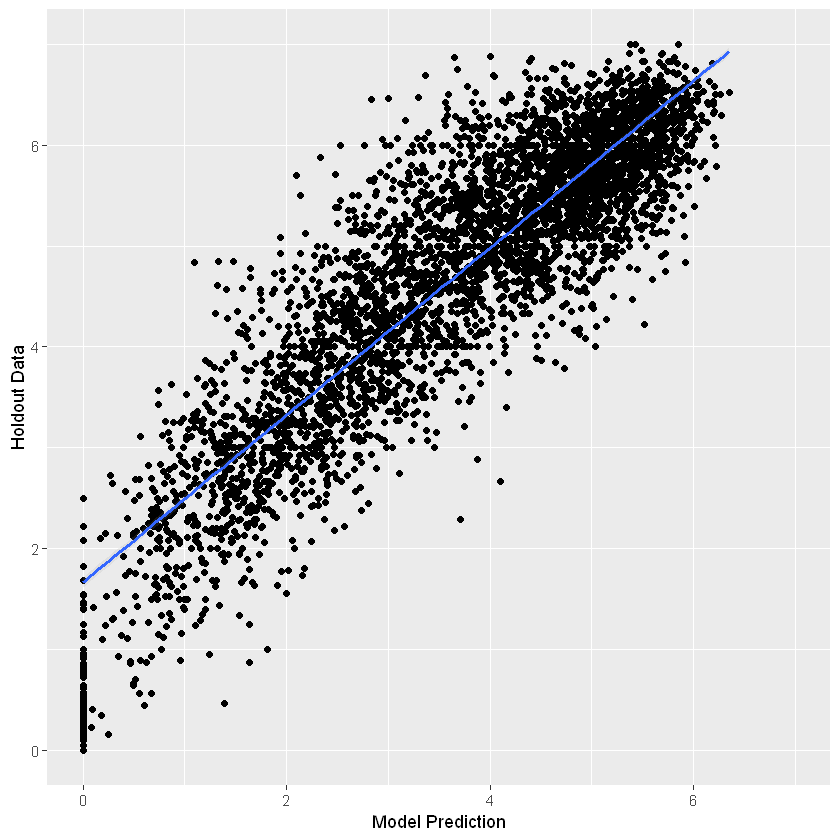

In [279]:
# format the training & test data
cv.data.judge <- split.data(clean.data, 2, method='data')

test.data <- cv.data.judge[[2]]
test.data.avg <- group.avg.df(test.data, colourSetHEX)

#print(head(cv.data.judge)) # testing

train.50 <- group.avg.df(cv.data.judge[[1]], colourSetHEX)
train.50.mat <- matrix.df.fill(train.50,color.mat.df)

#print(train.50.mat) # testing
#print(nrow(train.50.mat))
#print(ncol(train.50.mat))

train.50.mds <- cmdscale(data2dist(train.50.mat),k=3, eig=TRUE)
#print(head(train.50.mds))
train.50.mds2df <- mds2df(train.50.mds)

plot <- cor.plot(train.50.mds2df,test.data.avg,
                 xlabel='Model Prediction',ylabel='Holdout Data')

In [281]:
head(train.50.mds2df)$value[2]

[1] 0.9760165

In [288]:
# find the error
error_mds <- function(test.data, model){
    sum = 0
    for(i in 1:nrow(test.data)){
        e = (test.data$value[i] - model$value[i])^2
        sum = sum + e
    }
    return(sum)
}

In [289]:
error_mds(test.data.avg, train.50.mds2df)

[1] 6842.543

In [290]:
error_mds(train.50, train.50.mds2df)

[1] 6817.937

In [300]:
SSE(train.50.mds2df)

Warning message in mean.default(lm$fitted.values):
"argument is not numeric or logical: returning NA"


[1] "SSE: 0"


[1] 0

In [301]:
lm.50 <- lm(value~value.1, data = plot)

In [302]:
summary(lm.50)
SSE(lm.50)
SSE(lm.50)/var(test.data.avg$value)


Call:
lm(formula = value ~ value.1, data = plot)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.70860 -0.47205  0.04495  0.47946  2.37657 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.80830    0.03671  -22.02   <2e-16 ***
value.1      0.95188    0.00746  127.60   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6998 on 4369 degrees of freedom
Multiple R-squared:  0.7884,	Adjusted R-squared:  0.7884 
F-statistic: 1.628e+04 on 1 and 4369 DF,  p-value: < 2.2e-16


[1] "SSE: 7973.3362558689"


[1] 7973.336

[1] "SSE: 7973.3362558689"


[1] 3959.563